# 다음에 구매할 아이템 예측 추천 시스템


고객에게 그 고객과 유사한 다른 고객이 좋아하는 상품을 추천해 주는 전략은 언제나 유효할까?  고객의 선호가 고정된 것이라고 보는 추천 전략에는 맹점이 있다. 고객의 마음은 늘 변덕스럽기 때문에 전자상거래 플랫폼에서는 '바로 지금 시점에 이 고객이 좋아할 만한 상품'을 추천해 주고 싶어한다.

Session-Based Recommendation은 세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천을 말한다.

Session이란 앞에서 살펴보았듯이 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하며, 서버 쪽에 저장된다. 유저의 행동 데이터들은 유저 측 브라우저를 통해 쿠키의 형태로 저장되는데 쿠키는 세션과 상호작용하면서 정보를 주고받는다.

이번 프로젝트에서는 세션을 브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터와 같은 의미로 사용한다.

## 1. Data Preprocess

### 1.1 &nbsp;데이터 설명(README) 

In [1]:
import os
f = open(os.getenv('HOME')+'/aiffel/yoochoose/data/dataset-README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

﻿SUMMARY




This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.

See  http://recsys.yoochoose.net for details about the challenge.



The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session

is encapsulating the click events that the user performed in the session.

For some of the sessions, there are also buy events; means that the session ended

with the user bought something from the web shop. The data was collected during several

months in the year of 2014, reflecting the clicks and purchases performed by the users

of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,

all numbers have been modified. Do not try to reveal the identity of the retailer.



LICENSE


This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0

International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd

데이터 설명을 읽어보면 
1. 유저에 대한 정보를 전혀 알 수 없음 (성별, 나이, 장소, 마지막 접속 날짜, 이전 구매 내역 등등)
2. 아이템에 대한 정보도 전혀 알 수 없음 (실제로 어떤 물건인지, 사진이나 설명, 가격)

이와 달리 유저에 대한 정보를 알 수 있는 경우는 보통 Sequential Recommendation 이라고 구별해서 부르기도 한다. 유저와 아이템의 추가 정보를 Sequential Recommendation 모델에 적용하는 분야는 Context-Aware 라는 키워드로 활발히 연구되고 있다.

또한 E-Commerce 데이터의 경우 다음과 같은 특징을 갖는다.
1. 비로그인 상태로 탐색하는 유저가 많음
2. 로그인 상태로 탐색한다고 할지라도 접속할 때마다 탐색하는 의도가 뚜렷하게 다름

즉, 마우스를 사야겠다고 마음먹고 탐색한 이력이 칫솔을 사야겠다 생각하고 탐색하는 경우에 도움이 되지 않는다.



<br>

### 1.2 &nbsp;데이터 로드

데이터를 불러와 살펴보고 주요 통계치들을 살펴보자.  
해당 프로젝트에서는 Click 데이터에 있는 Session Id, TimeStamp, ItemId 컬럼만 사용하겠다.

In [3]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data') 
train_path = data_path / 'yoochoose-clicks.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/yoochoose-clicks.dat')

In [5]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [6]:
# 시간 소요
data = load_data(train_path, None)
data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬
data

,SessionId,Time,ItemId
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,2,2014-04-07 13:56:37.614000+00:00,214662742
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수다.

In [7]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(9249729, 52739)

세션의 숫자가 약 900만 개, 아이템 숫자는 약 5만 개가 된다.  
이 수치가 유저의 수가 900만 명이라는 것은 아니다. 같은 유저가 여러 개의 세션을 만들 수도 있기 때문이다.

<br>

### 1.3 &nbsp;Session Length

각 세션이 대략 몇 개의 클릭 데이터를 갖는지 확인한다.

여기서 session_length란 같은 SessionId를 공유하는 데이터 row의 개수를 의미한다. 여기서 SessionId란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자이다. 로그인하지 않았기 때문에 이 사용자가 누군지는 알 수 없어도, 최소한 특정 사용자의 행동을 SessionId 기준으로 모아서 분류해낼 수는 있다.

따라서 여기서 session_length란, 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지(몇 개의 상품정보를 클릭했는지)의 의미가 된다.

In [10]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1           4
2           6
3           3
4           2
6           2
           ..
11562156    2
11562157    2
11562158    3
11562159    1
11562161    1
Length: 9249729, dtype: int64

In [11]:
session_length.median(), session_length.mean()

(2.0, 3.568098481587947)

In [12]:
session_length.min(), session_length.max()

(1, 200)

In [13]:
session_length.quantile(0.999)

41.0

- 각 세션의 길이는 보통 2~3 정도이다.
    온라인에서 쇼핑할 때를 생각해 보면 이 수치가 그럴듯하게 느껴진다.
- 99.9% 세션은 길이가 41이하이다.
- 길이가 200인 세션은 뭔가 이상하다.

In [15]:
# 길이가 200인 세션 하나 확인하기
long_session = session_length[session_length==200].index[0]
data[data['SessionId']==long_session]

,SessionId,Time,ItemId
580293,189448,2014-04-01 08:56:28.983000+00:00,214830392
580294,189448,2014-04-01 08:56:31.815000+00:00,214830392
580295,189448,2014-04-01 08:57:08.301000+00:00,214830392
580296,189448,2014-04-01 08:57:10.338000+00:00,214830392
580297,189448,2014-04-01 08:58:01.728000+00:00,214830390
...,...,...,...
580488,189448,2014-04-01 10:35:52.400000+00:00,214830137
580489,189448,2014-04-01 10:37:15.094000+00:00,214830118
580490,189448,2014-04-01 10:37:35.955000+00:00,214830118
580491,189448,2014-04-01 10:37:37.098000+00:00,214830118


매우 짧은 간격으로 지속적으로 클릭을 1시간 30분가량 지속하고 있다.

유저들의 서비스 이용행태는 다양하기 때문에 데이터 전처리를 어떻게 할지는 모델을 만드는 사람이 판단해야 한다.  
- e.g., 음악 데이터의 경우 어떤 사람은 하루 종일 랜덤 재생을 할 수도 있다. 이 유저의 데이터를 그대로 사용하는 게 좋을까?  
- e.g., 어떤 상품의 경우 1분 내에 20명이 10점을 주고 나갈 수도 있다. 이 상품을 팔기 위해 조작하고 있는 건 아닐까요?  

너무 긴 세션을 제거할 수도 있고 포함시킬 수도 있다.


세션 길이에 대한 감을 더 잘 파악하기 위해 시각화를 해보겠다.  
아래는 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것이다.

In [16]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1     0.136189
2     0.520858
3     0.695280
4     0.796461
5     0.855125
6     0.894389
7     0.920036
8     0.938321
9     0.951293
10    0.961084
11    0.968267
12    0.973959
13    0.978320
14    0.981815
15    0.984587
16    0.986837
17    0.988673
18    0.990201
19    0.991460
20    0.992520
21    0.993436
22    0.994207
23    0.994871
24    0.995444
25    0.995920
26    0.996342
27    0.996714
28    0.997042
29    0.997330
30    0.997577
31    0.997796
32    0.998001
33    0.998177
34    0.998327
35    0.998461
36    0.998590
37    0.998706
38    0.998805
39    0.998896
40    0.998981
dtype: float64

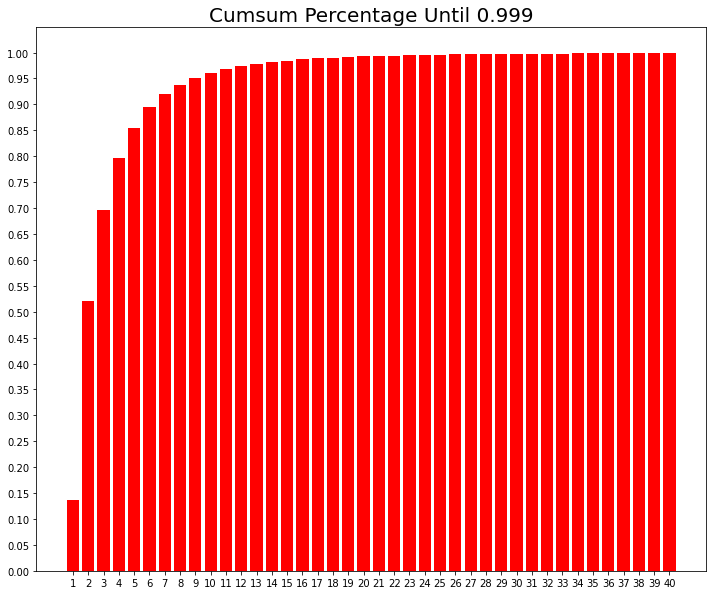

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

Q. 추천시스템은 유저-상품 관계 매트릭스를 유저 행렬과 상품 행렬의 곱으로 표현하는 Matrix Factorization 모델을 널리 사용한다. 그렇다면 이 데이터도 유저와 클릭한 상품정보 관계에 대해 Matrix Factorization을 사용하면 어떨까?  
A. User * Item Matrix의 빈칸이 너무 많아서(data sparsity) 모델이 제대로 학습되지 않을 가능성이 있다. 이 세션정보는 유저를 ID 기반으로 정리할 수 없기 때문에 세션 하나를 유저 하나로 본다면 기존의 유저-상품정보 Matrix보다 훨씬 sparse한 형태가 된다.



<br>

### 1.4 &nbsp;Session Time

- 어떤 유저가 아이폰을 구매하려고 한다. 2020년 5월에는 아이폰 SE2를 구매하려는 사람이 많을 것이다.
- 그러나 그로부터 몇 달 후면 아이폰 12의 구매량이 엄청나게 증가하게 될 것이다.

영화나 드라마 역시 마찬가지다. 유저들의 소비 패턴을 금방금방 변한다. 이런 이유 때문에 추천 시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요하다.

이번에는 데이터가 발생한 시간에 대해 알아보자.  
추천 시스템에서 다루는 시간 관련 데이터는 다양한 측면이 있다.
- 접속하는 시간대(오전, 오후, 새벽), 접속해 있는 시간, 접속하는 요일, 계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등등

In [18]:
# 데이터의 시간 관련 정보 확인
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2014-04-01 03:00:00.124000+00:00
2014-09-30 02:59:59.430000+00:00


데이터 설명대로 6개월치 데이터가 있고, 한 달 치 데이터만 사용하려고 한다.

In [20]:
month_ago = latest - dt.timedelta(30)  # 최종 날짜로부터 30일 이전 날짜를 구하기 
data = data[data['Time'] > month_ago]  # 방금 구한 날짜 이후의 데이터만 모으기
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838214,9194112,2014-09-01 13:26:36.292000+00:00,214853422
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


<br>

### 1.5 &nbsp;Data Cleansing

앞서 살펴봤듯이 길이가 1인 세션도 꽤 있다.

해당 프로젝트의 목적은 유저가 최소 2개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해 준다.  

너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있다. 이 역시 제거해 준다.

In [22]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있음
# 이를 위해 반복문을 통해 지속적으로 제거함
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [23]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207
...,...,...,...
32230485,11562157,2014-09-25 12:31:10.391000+00:00,214580372
32230486,11562157,2014-09-25 12:31:29.679000+00:00,214516012
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774


<br>

### 1.6 &nbsp;Train / Valid / Test split

모델 평가를 위해 Valid Set과 Test Set을 만든다.  
대회에서 Test Set을 제공해 주고 있다.

In [24]:
test_path = data_path / 'yoochoose-test.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(Timestamp('2014-04-01 03:00:08.250000+0000', tz='UTC'),
 Timestamp('2014-09-30 02:59:23.866000+0000', tz='UTC'))

Test 셋을 살펴보니 Training 셋과 기간이 겹친다. 하지만 추천 시스템은 지금 잘 예측하는 게 중요하다. 한 달 전에 성능이 좋은 모델을 지금 쓰면 맞지 않을 수가 있는데, 사용자들의 소비 패턴이 달라지기 때문이다.

이런 이유로 Session-Based Recommendation에서는 기간에 따라 Train/ Valid/ Test 셋을 나누기도 한다. 해당 데이터에서는 가장 마지막 1일 기간 동안을 Test로, 2일 전부터 1일 전 까지를 valid set으로 나누겠다.
- Train(1일~28일) + Valid(29일) + Test(30일)

In [25]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [26]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [27]:
# data 정보 살펴보기
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [28]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125100
	 Sessions: 1243431
	 Items: 20153
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58074
	 Sessions: 12350
	 Items: 6232
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71009
	 Sessions: 15289
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [29]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

이제 데이터 준비를 마쳤다.  
데이터를 저장한 다음 data pipeline을 구축하는 단계로 넘어간다.

In [31]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

<br>
<br>

## 2. Data Pipeline

Session-Parallel Mini-Batch 를 구현한다.

### 2.1 &nbsp;SessionDataset

데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다.

In [34]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

train 데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴본다.  

click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있다.  
session_idx 변수는 각 세션을 인덱싱한 np.array다.

In [35]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [36]:
tr_dataset.click_offsets

array([      0,       4,       6, ..., 5125095, 5125097, 5125100],
      dtype=int32)

In [37]:
tr_dataset.session_idx

array([      0,       1,       2, ..., 1243428, 1243429, 1243430])

<br>

### 2.2 &nbsp;SessionDataLoader

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만든다.  

\_\_iter\_\_ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield한다.  
mask는 후에 RNN Cell State를 초기화하는데 사용할 것이다.

In [38]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옴
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둠
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옴
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옴
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것
        finished = False      # data를 전부 돌았는지 기록하기 위한 변수
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줌
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻 -> mask에 기록

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌 것
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치 기록
        return start, end, mask, last_session, finished

In [39]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [40]:
iter_ex = iter(tr_data_loader)

In [41]:
# 반복 실행하면 next가 계속 다음 데이터를 만듦
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 7]
Label Item Idx are :       [1 4 6 7]
Previous Masked Input Idx are []


<br>
<br>

## 3. Modeling

### 3.1 &nbsp;Evaluation Metric

Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/구매한 n개의 아이템이 많아야 좋다.

이 때문에 recall의 개념을 확장한 `recall@k` 지표, precision의 개념을 확장한 `Mean Average Precision@k` 지표 등을 사용한다.

추천에서는 몇 번째로 맞추느냐도 중요하다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것이다. 따라서 순서에 민감한 지표인 `MRR`, `NDCG` 같은 지표도 사용합니다.

해당 데이터에서는 `MRR` 과 `Recall@k` 를 사용하겠다.  
MRR은 정답 아이템이 나온 순번의 역수 값이다. 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것이다.

In [43]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

<br>

### 3.2 &nbsp;Model Architecture

해당 데이터에서 사용할 모델은 2016년 ICLR에 공개된 [SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS](https://arxiv.org/pdf/1511.06939v4)이다. Session Data에서는 처음으로 RNN 계열 모델을 적용하여 발표하였다.

모델 구조는 아래 그림처럼 간단하다.

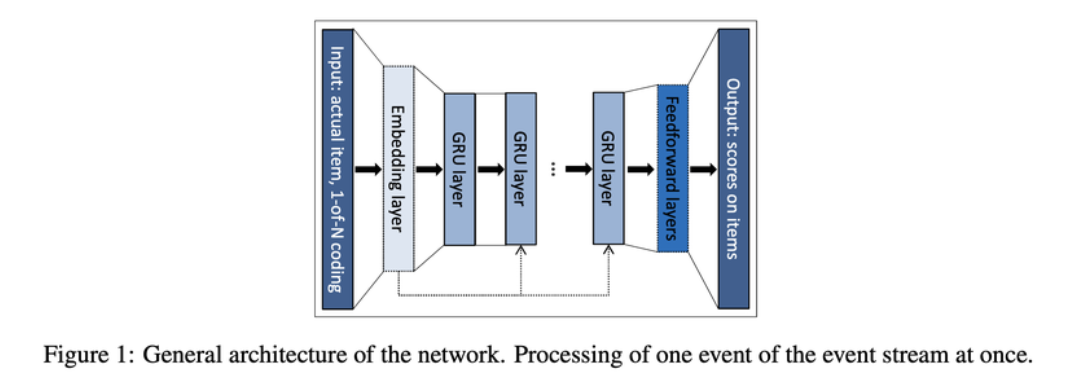

여러 RNN 계열의 모델(e.g. LSTM)이 있겠지만 저자가 실험해 본 결과, GRU의 성능이 제일 좋았다고 합니다. 또한 Embedding Layer를 사용하지 않았을 때가 사용했을 때보다 성능이 좋았다고 한다. 따라서 Embedding Layer를 사용하지 않고 One-hot Encoding만 사용하겠다.

대신, 추천 데이터의 특징 몇 가지를 살려 모델링한다.

**Session-Parallel Mini-Batches**:  
위에서 보았듯이 Session의 길이는 매우 짧은 것들이 대부분이다. 그러나 매우 긴 것들도 있다. 이 세션들을 데이터 샘플 하나로 보고 mini-batch를 구성하여 input으로 넣는다면 길이가 제일 긴 세션의 연산이 끝날 때까지 짧은 세션들이 기다려야 한다.

논문의 저자는 대신 Session-Parallel Mini-Batches를 제안한다. 이름처럼 Session이 끝날 때까지 기다리지 않고 병렬적으로 계산하자는 것이다. 아래 그림에서 session2가 끝나면 session4가 시작하는 방식이다. 

이렇게 구성했을 때 Mini-Batch의 shape은 (3, 1, 1)이 되고 RNN cell의 state가 1개로만 이루어진다. 또한 Tensorflow 기준으로 RNN을 만들 때 stateful=True 옵션을 사용하고 2처럼 세션이 끝나면 state를 0으로 만들어 준다.
- [참고] [RNN API](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN)

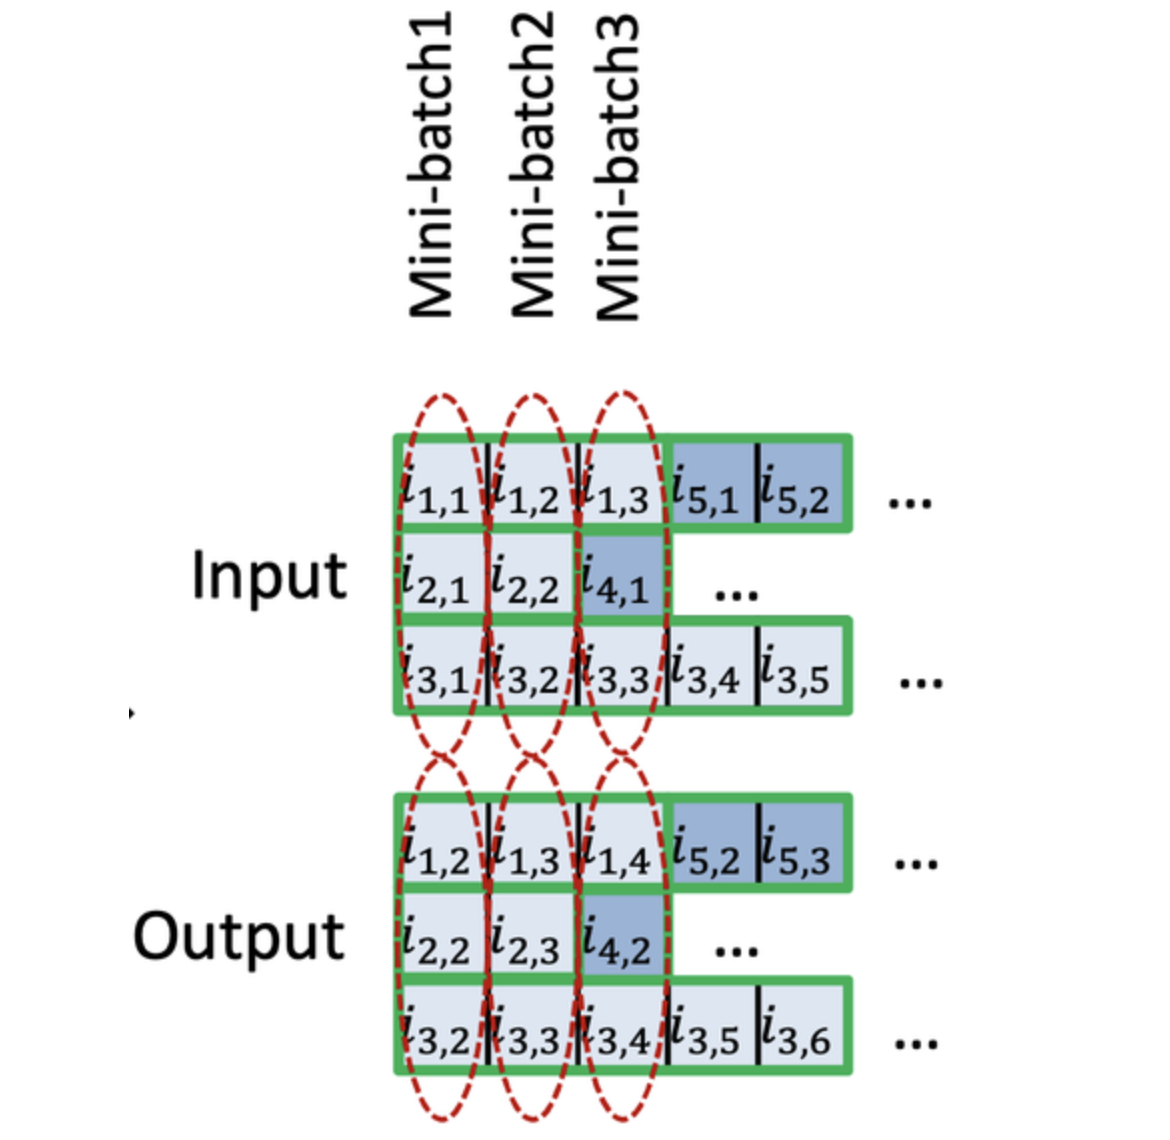

**SAMPLING ON THE OUTPUT**: Negative Sampling와 같은 개념이다. Item의 수가 많기 때문에 Loss를 계산할 때 모든 아이템을 비교하지 않고 인기도를 고려하여 Sampling한다. 해당 부분은 구현하지 않겠다.

**Ranking Loss**: Session-Based Recommendation Task를 여러 아이템 중 다음 아이템이 무엇인지 Classification하는 Task로 생각할 수도 있다. 그러나 여러 아이템을 관련도 순으로 랭킹을 매겨서 높은 랭킹의 아이템을 추천하는 Task로도 생각할 수 있습니다. 추천 시스템 연구 분야에서는 이렇게 Ranking을 맞추는 objective function에 대한 연구가 있었고 논문의 저자 역시 이런 Loss를 사용하였다. 그러나 해당 데이터에서는 Classification Task로 보고 Cross-Entropy Loss를 사용하겠다.

In [46]:
# 모델 구조가 간단한 편이므로 Functional하게 모델을 만들기
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [47]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [48]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [49]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20153)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  3030750   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20153)             1027803   
Total params: 4,058,553
Trainable params: 4,058,553
Non-trainable params: 0
_________________________________________________________________


<br>

### 3.3 &nbsp;Model Training

지금까지 준비한 데이터셋과 모델을 통해 학습을 진행해야 한다.  
모델 학습에 걸리는 시간은 epoch당 30분이 넘어가기 때문에 모델 학습 직전까지만 구현하였다.

- 참고) 배치 사이즈나 epoch 등의 설정은 위의 args에서 관리함






In [51]:
# train 셋으로 학습하면서 valid 셋으로 검증
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화 -> 아래 메서드에서 확인

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옴
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옴
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있음
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [52]:
# 학습 시간이 다소 오래 소요
# train_model(model, args)

# 학습된 모델 불러오기
model = tf.keras.models.load_model(data_path / 'trained_model')

<br>

### 3.4 &nbsp;Inference

지금까지 작성한 모델이 테스트셋에 대해서 어느 정도 성능을 내는지 검증한다.

In [53]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  81%|████████▏ | 22/27 [02:35<00:35,  7.06s/it]

	 - Recall@20: 0.686967
	 - MRR@20: 0.291214

